In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import symlib
from astropy.constants import G
from astropy import units as u
from colossus.cosmology import cosmology
import warnings

/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_32515/569793776.py:120: RuntimeWarning: invalid value encountered in log10
  log_gamma = np.log10(np.where(valid, accretion_rates, 1))


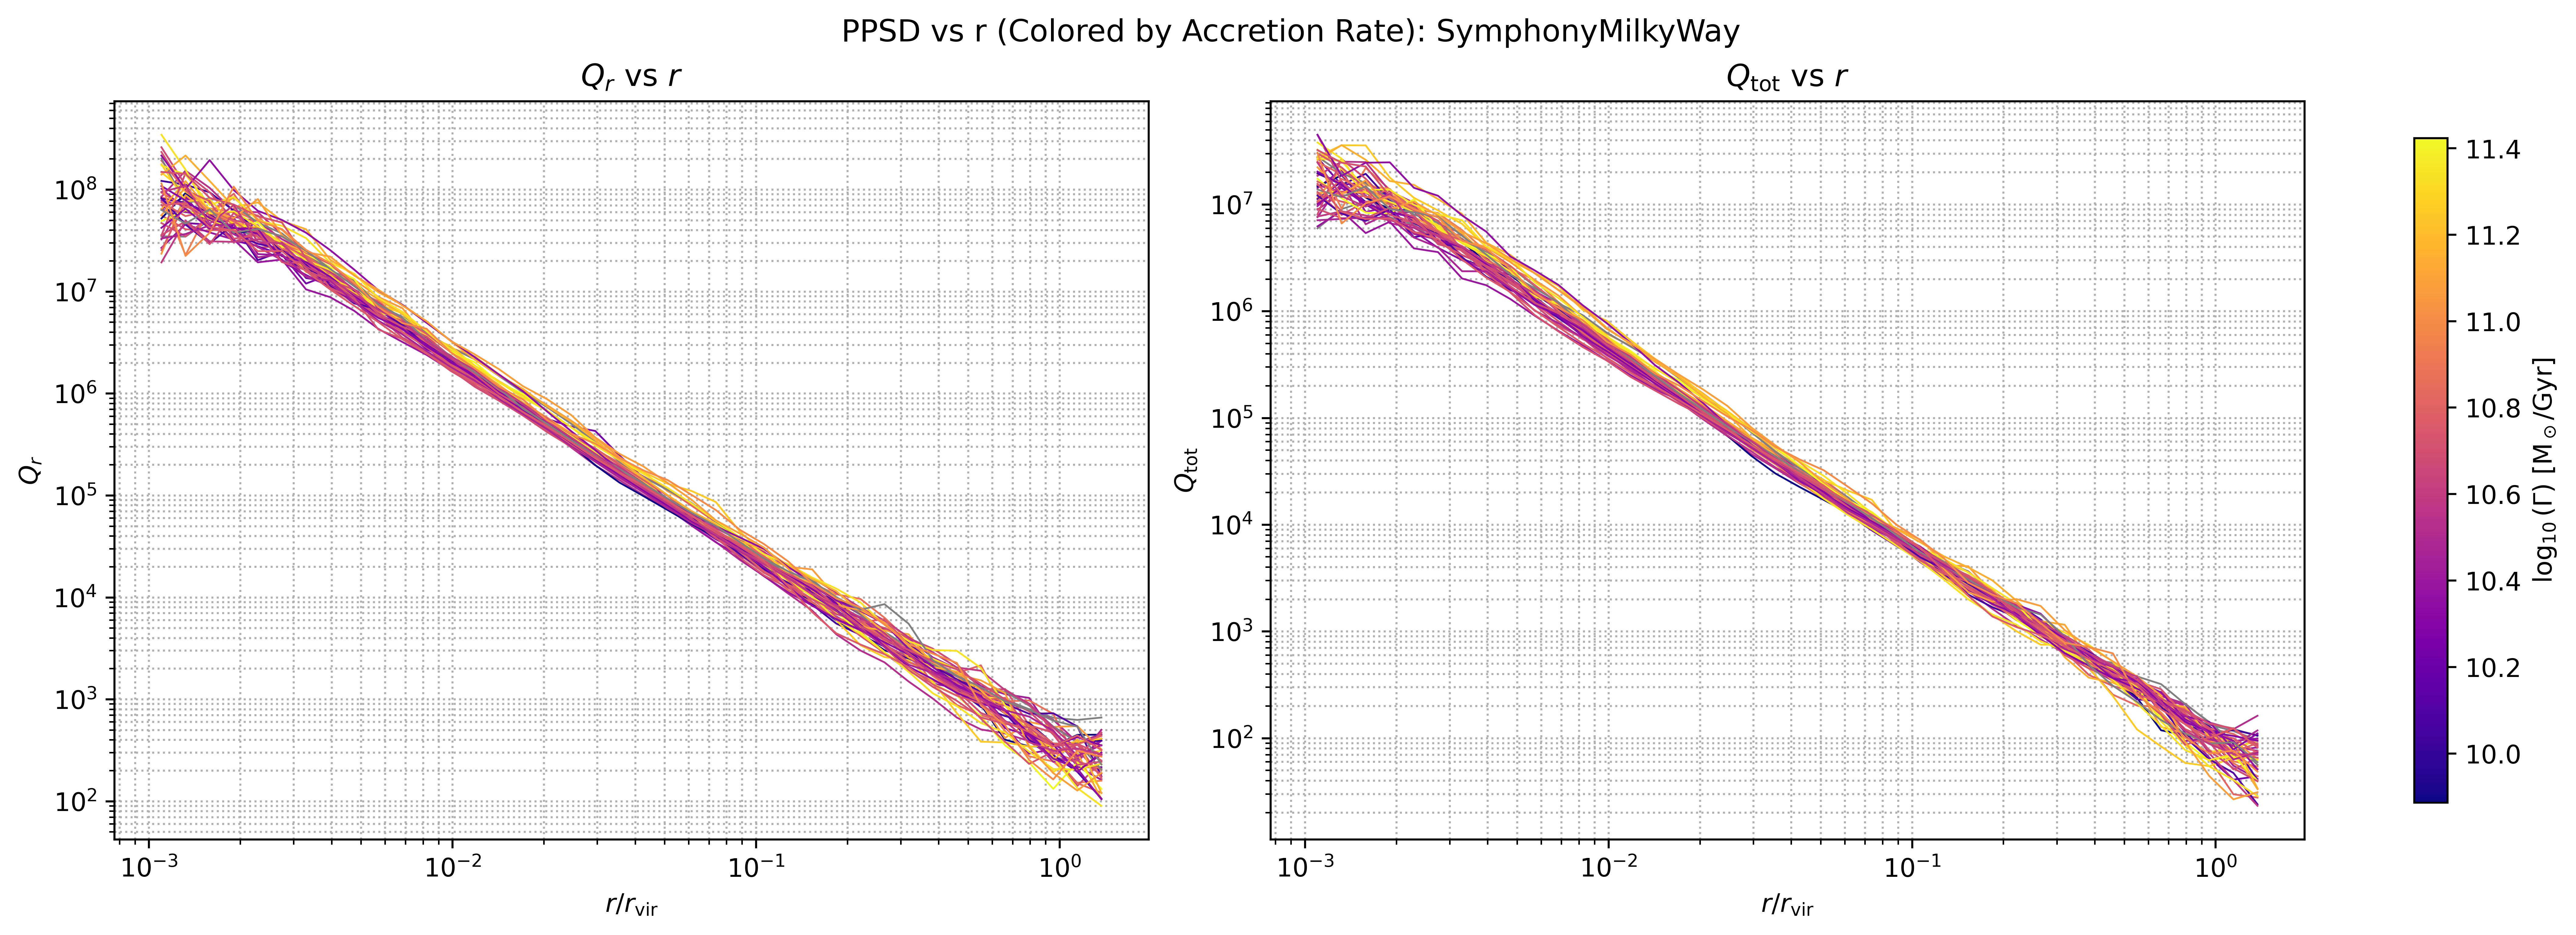

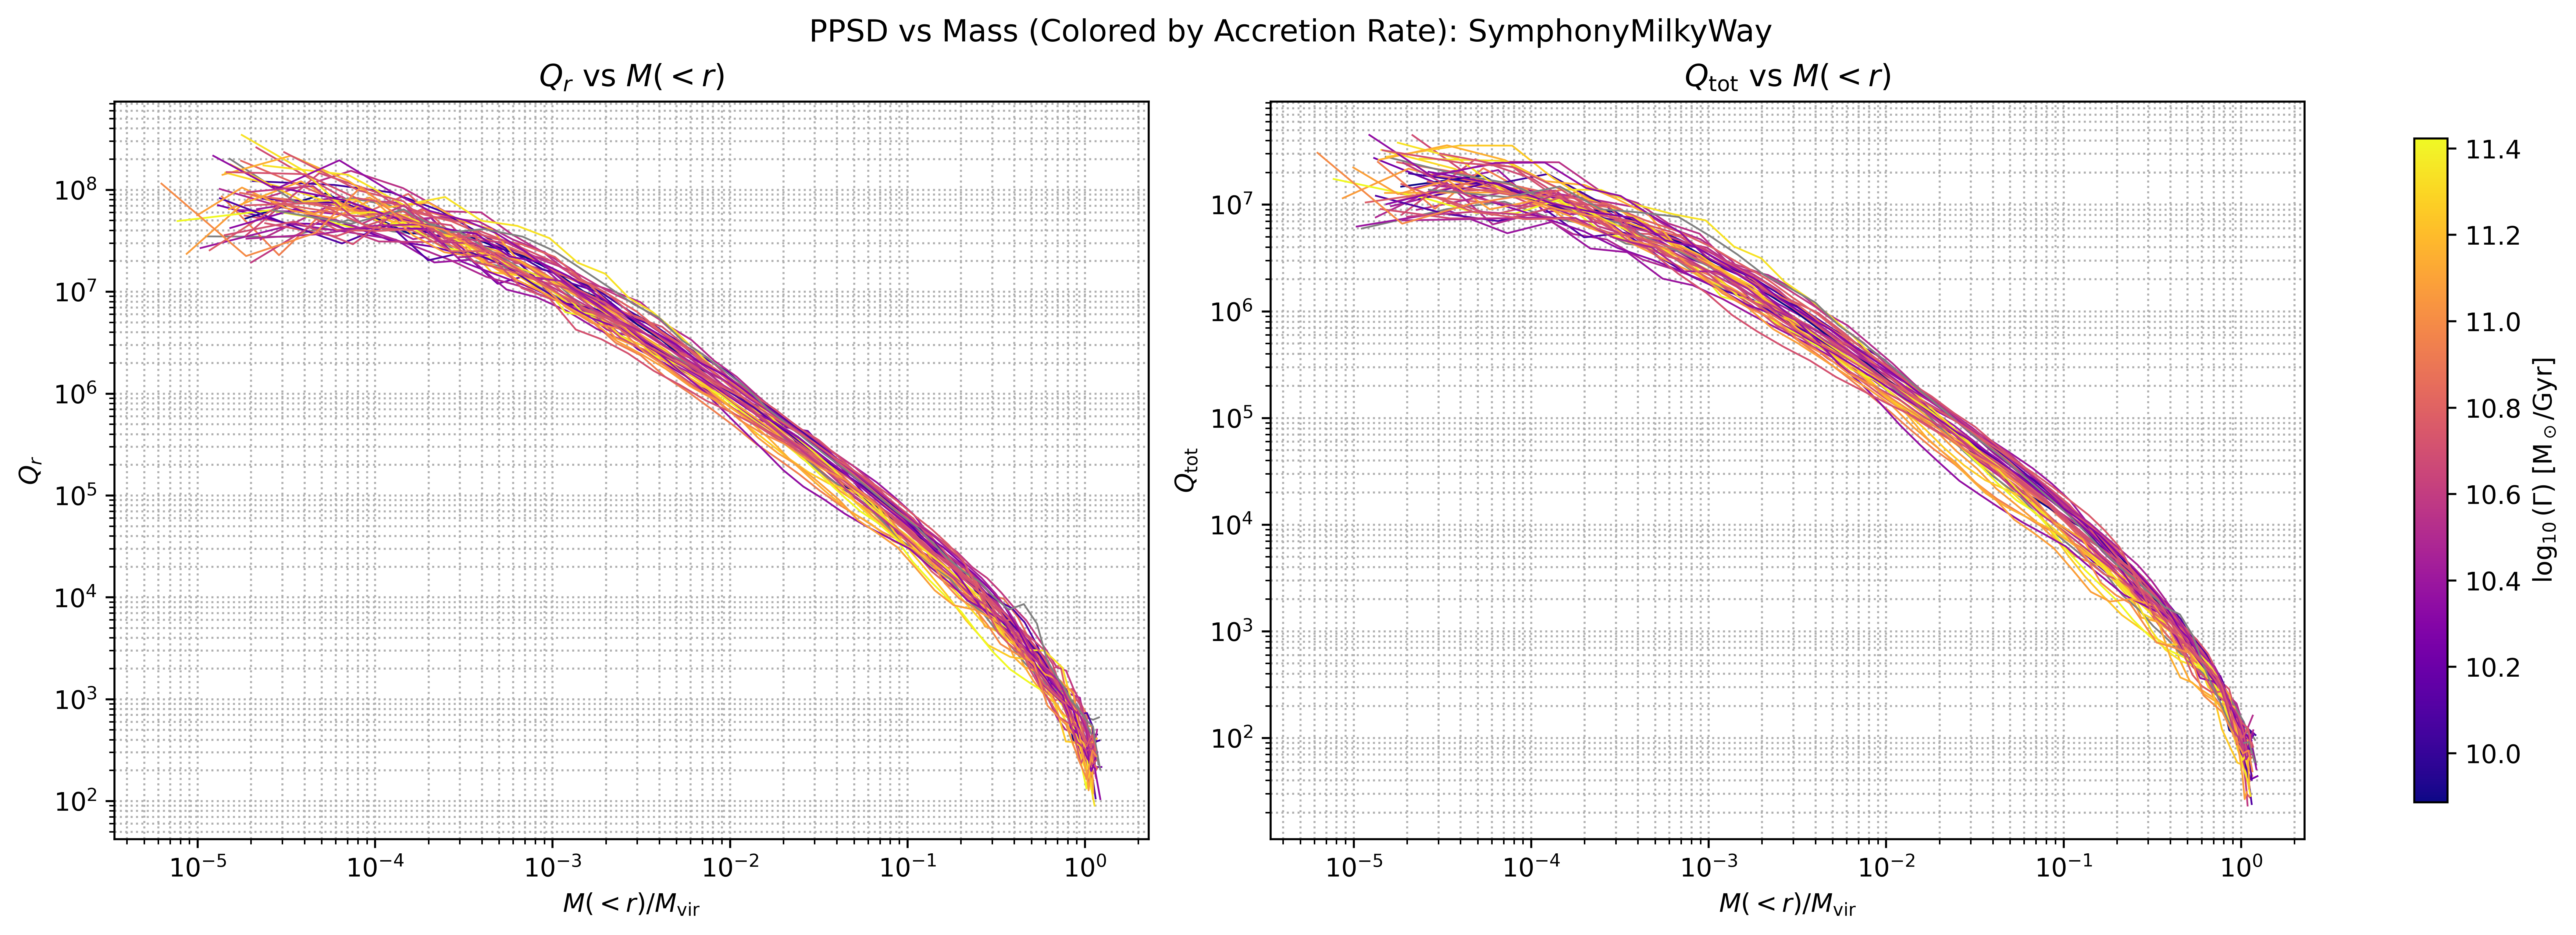

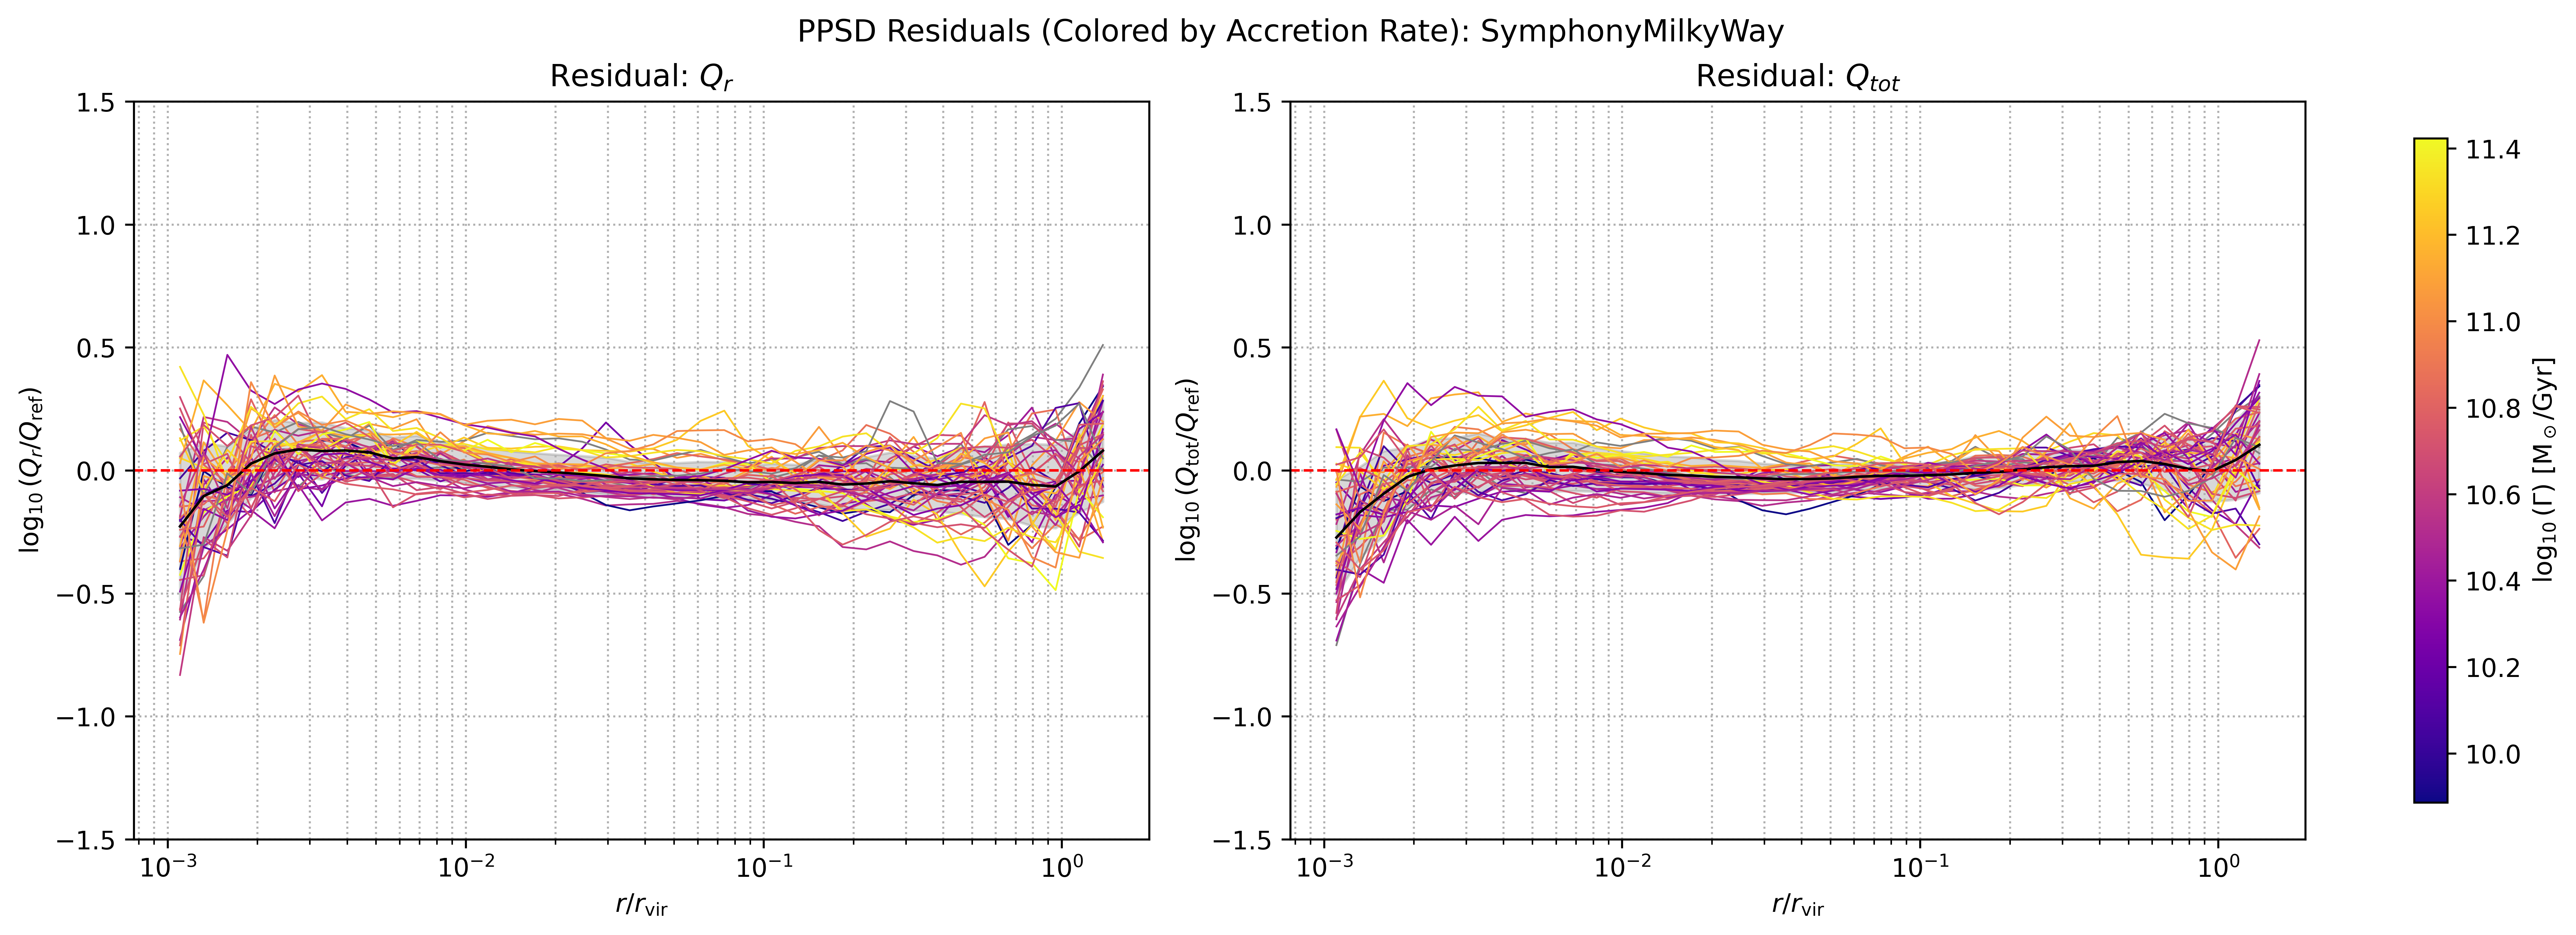

[Saved] All Accretion-Rate Colored PPSD Figures for SymphonyMilkyWay


In [29]:
import traceback
def ppsd_profiles_colored_by_accretion_rate(base_dir, suite_name):
    # --- Setup paths ---
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    mass_dir = os.path.join(base_dir, "output", suite_name, "mass_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    mass_files = sorted([f for f in os.listdir(mass_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
    n_halos = len(density_files)

    ppsd_r, ppsd_tot, mass_profiles, accretion_rates = [], [], [], []
    r_global = None  

    # --- Compute accretion rates ---
    def calculate_accretion_rate(sim_dir):
        try:
            # Load cosmology and snapshot
            scale = symlib.scale_factors(sim_dir)
            r, _ = symlib.read_rockstar(sim_dir)
            snap = len(scale) - 1  # z=0
            m_now = r[0, snap]["m"]

            # Set up cosmology
            sim_params = symlib.simulation_parameters(sim_dir)
            cosmo = cosmology.setCosmology("custom", {
                "flat": sim_params["flat"],
                "H0": sim_params["H0"],
                "Om0": sim_params["Om0"],
                "Ob0": sim_params["Ob0"],
                "sigma8": sim_params["sigma8"],
                "ns": sim_params["ns"]
            })

            rho_m0 =cosmo.rho_m(0) # M_sun * h^2 / kpc^3
            Delta = 99
            rho_vir = Delta * rho_m0 * 1e9 / sim_params["h100"]**2 # M_sun / Mpc^3
            G_val = G.to(u.Mpc**3 / (u.Msun * u.Gyr**2)).value  # Mpc^3 / (Msun * Gyr^2)
            t_dyn = 1.0 / np.sqrt((4/3) * np.pi * G_val * rho_vir)  # Gyr
            
            times = cosmo.age(1 / scale - 1)  # Gyr
            t0 = times[snap]
            t_past = t0 - t_dyn
            snap_past = np.argmin(np.abs(times - t_past))
            m_past = r[0, snap_past]["m"]

            gamma = (m_now - m_past) / t_dyn  # Msun/Gyr

            return gamma

        except Exception as e:
            traceback.print_exc() 
            warnings.warn(f"Error calculating accretion rate: {e}")
            return np.nan
    
    # --- Loop through halos ---
    for i in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, i)
        gamma = calculate_accretion_rate(sim_dir)
        accretion_rates.append(gamma)

        try:
            df_rho = pd.read_csv(os.path.join(density_dir, density_files[i]))
            df_mass = pd.read_csv(os.path.join(mass_dir, mass_files[i]))
            df_vel = pd.read_csv(os.path.join(velocity_dir, velocity_files[i]))
        except:
            print(f"[Warning] Profile load failed for halo {i}")
            continue

        r = df_rho["r_scaled"].values
        if r_global is None: r_global = r.copy()
        rho = df_rho["rho_scaled"].values
        mass = df_mass["m_scaled"].values
        sigma_rad = df_vel["sigma_rad_scaled"].values
        sigma_total = df_vel["sigma_total_scaled"].values

        Q_r = np.where(sigma_rad > 0, rho / sigma_rad**3, np.nan)
        Q_tot = np.where(sigma_total > 0, rho / sigma_total**3, np.nan)

        ppsd_r.append(Q_r)
        ppsd_tot.append(Q_tot)
        mass_profiles.append(mass)

    ppsd_r = np.array(ppsd_r)
    ppsd_tot = np.array(ppsd_tot)
    mass_profiles = np.array(mass_profiles)
    accretion_rates = np.array(accretion_rates)

    # --- Compute reference power-law ---
    mean_Qr = np.nanmean(ppsd_r, axis=0)
    mean_Qtot = np.nanmean(ppsd_tot, axis=0)
    log_r = np.log(r_global)

    A_r = np.exp(np.mean(np.log(mean_Qr) + 1.875 * log_r))
    A_tot = np.exp(np.mean(np.log(mean_Qtot) + 1.875 * log_r))
    ref_curve_r = A_r * r_global**(-1.875)
    ref_curve_tot = A_tot * r_global**(-1.875)

    # --- Residuals ---
    residuals_r, residuals_tot = [], []
    for i in range(n_halos):
        res_r = np.log10(ppsd_r[i]) - np.log10(ref_curve_r)
        res_t = np.log10(ppsd_tot[i]) - np.log10(ref_curve_tot)
        residuals_r.append(res_r)
        residuals_tot.append(res_t)

    residuals_r = np.array(residuals_r)
    residuals_tot = np.array(residuals_tot)
    mean_res_r = np.nanmean(residuals_r, axis=0)
    std_res_r = np.nanstd(residuals_r, axis=0)
    mean_res_tot = np.nanmean(residuals_tot, axis=0)
    std_res_tot = np.nanstd(residuals_tot, axis=0)

    # --- Colormap ---
    cmap = cm.plasma
    valid = ~np.isnan(accretion_rates)
    log_gamma = np.log10(np.where(valid, accretion_rates, 1))
    norm = plt.Normalize(vmin=np.nanmin(log_gamma[valid]), vmax=np.nanmax(log_gamma[valid]))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # --- Plot 1: Q vs r ---
    fig1, ax1 = plt.subplots(1, 2, figsize=(14, 5), dpi=600, constrained_layout=True)
    for i in range(n_halos):
        color = 'gray' if np.isnan(log_gamma[i]) else cmap(norm(log_gamma[i]))
        ax1[0].plot(r_global, ppsd_r[i], color=color, lw=0.7)
        ax1[1].plot(r_global, ppsd_tot[i], color=color, lw=0.7)

    ax1[0].set(title=r"$Q_r$ vs $r$", xscale="log", yscale="log",
               xlabel=r"$r / r_{\rm vir}$", ylabel=r"$Q_r$")
    ax1[1].set(title=r"$Q_{\rm tot}$ vs $r$", xscale="log", yscale="log",
               xlabel=r"$r / r_{\rm vir}$", ylabel=r"$Q_{\rm tot}$")
    for ax in ax1: ax.grid(True, which="both", linestyle=":")
    cbar1 = fig1.colorbar(sm, ax=ax1.ravel().tolist(), shrink=0.9)
    cbar1.set_label(r"$\log_{10}(\Gamma)$ [M$_\odot$/Gyr]")
    fig1.suptitle(f"PPSD vs r (Colored by Accretion Rate): {suite_name}")
    fig1.savefig(os.path.join(output_dir, "PPSD_vs_r_colored_by_accretion.png"))
    plt.show()
    plt.close(fig1)

    # --- Plot 2: Q vs M(<r) ---
    fig2, ax2 = plt.subplots(1, 2, figsize=(14, 5), dpi=600, constrained_layout=True)
    for i in range(n_halos):
        color = 'gray' if np.isnan(log_gamma[i]) else cmap(norm(log_gamma[i]))
        ax2[0].plot(mass_profiles[i], ppsd_r[i], color=color, lw=0.7)
        ax2[1].plot(mass_profiles[i], ppsd_tot[i], color=color, lw=0.7)

    ax2[0].set(title=r"$Q_r$ vs $M(<r)$", xscale="log", yscale="log",
               xlabel=r"$M(<r)/M_{\rm vir}$", ylabel=r"$Q_r$")
    ax2[1].set(title=r"$Q_{\rm tot}$ vs $M(<r)$", xscale="log", yscale="log",
               xlabel=r"$M(<r)/M_{\rm vir}$", ylabel=r"$Q_{\rm tot}$")
    for ax in ax2: ax.grid(True, which="both", linestyle=":")
    cbar2 = fig2.colorbar(sm, ax=ax2.ravel().tolist(), shrink=0.9)
    cbar2.set_label(r"$\log_{10}(\Gamma)$ [M$_\odot$/Gyr]")
    fig2.suptitle(f"PPSD vs Mass (Colored by Accretion Rate): {suite_name}")
    fig2.savefig(os.path.join(output_dir, "PPSD_vs_mass_colored_by_accretion.png"))
    plt.show()
    plt.close(fig2)

    # --- Plot 3: Residuals ---
    fig3, ax3 = plt.subplots(1, 2, figsize=(14, 5), dpi=600, constrained_layout=True)
    for i in range(n_halos):
        color = 'gray' if np.isnan(log_gamma[i]) else cmap(norm(log_gamma[i]))
        ax3[0].plot(r_global, residuals_r[i], color=color, lw=0.7)
        ax3[1].plot(r_global, residuals_tot[i], color=color, lw=0.7)

    for ax, mean_res, std_res, label in zip(ax3, [mean_res_r, mean_res_tot], [std_res_r, std_res_tot],
                                            [r"$\log_{10}(Q_r/Q_{\rm ref})$", r"$\log_{10}(Q_{\rm tot}/Q_{\rm ref})$"]):
        ax.plot(r_global, mean_res, 'k-', lw=1)
        ax.fill_between(r_global, mean_res - std_res, mean_res + std_res, color='gray', alpha=0.3)
        ax.axhline(0, color='r', linestyle='--', lw=1)
        ax.set(xscale="log", ylim=(-1.5, 1.5), ylabel=label, xlabel=r"$r / r_{\rm vir}$")

    ax3[0].set_title("Residual: $Q_r$")
    ax3[1].set_title("Residual: $Q_{tot}$")
    for ax in ax3: ax.grid(True, which="both", linestyle=":")
    cbar3 = fig3.colorbar(sm, ax=ax3.ravel().tolist(), shrink=0.9)
    cbar3.set_label(r"$\log_{10}(\Gamma)$ [M$_\odot$/Gyr]")
    fig3.suptitle(f"PPSD Residuals (Colored by Accretion Rate): {suite_name}")
    fig3.savefig(os.path.join(output_dir, "PPSD_residuals_colored_by_accretion.png"))
    plt.show()
    plt.close(fig3)

    print(f"[Saved] All Accretion-Rate Colored PPSD Figures for {suite_name}")

base_dir = "/Volumes/Atlas/Symphony"
suite_name = "SymphonyMilkyWay"
ppsd_profiles_colored_by_accretion_rate(base_dir, suite_name)